In [3]:
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure
from skimage.measure import regionprops, label
from scipy.spatial import distance
import time
import datetime
from mpl_toolkits.mplot3d import Axes3D  # 3D Plotting
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


#  Calculation of  non-dimensional  shape factors for the track cells across multiple frames and store results by Cell ID.

In [4]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255  # Convert to 0-255 format
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}
    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = region.centroid
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            cell_tracks[matched_cell_id] = centroid
            all_results.append([matched_cell_id, frame] + shape_factors)

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation","Circularity", "Convexity"]
    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"tracked_cells_{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df


########  Example usage
# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"                           ####### Update with your directory path
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
# results_df = analyze_cells_across_frames(mask_directory, output_directory)


mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"                           
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head(10))

Found 100 mask files.
Execution Time: 21.37 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19791.0  1305.303607  0.745677  0.512826   
1            1  mask0022  15973.0  1015.605122  0.806229  0.676449   
2            1  mask0026  24764.0  1642.315801  0.796424  0.554153   
3            2  mask0000  20178.0   740.918831  0.827374  0.622240   
4            2  mask0001  20663.0   694.090404  0.849385  0.620678   
5            2  mask0002  19913.0   695.019336  0.831788  0.642853   
6            2  mask0003  18146.0   750.818326  0.806023  0.605432   
7            2  mask0004  20733.0   885.144228  0.790009  0.620823   
8            2  mask0005  17514.0   668.776695  0.863950  0.647995   
9            2  mask0006  19168.0   725.303607  0.834770  0.614359   

   Compactness  Elongation  Circularity  Convexity  
0     0.145967    0.979877     0.936470   0.230860  
1     0.194602    0.973082     0.912320   0.276314  
2     0.115376    

#  Calculation of  non-dimensional  shape factors for the HP4_TRA across multiple frames and store results by Cell ID (/data/MinaHossain/Cell_Data/Fall-2024/Track_Result).

In [5]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255  # Convert to 0-255 format
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}
    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = region.centroid
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            cell_tracks[matched_cell_id] = centroid
            all_results.append([matched_cell_id, frame] + shape_factors)

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation","Circularity", "Convexity"]
    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"tracked_cells_HP4{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df


########  Example usage
# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"                           ####### Update with your directory path
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
# results_df = analyze_cells_across_frames(mask_directory, output_directory)


mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"                           
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head(10))

Found 100 mask files.
Execution Time: 21.41 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19791.0  1305.303607  0.745677  0.512826   
1            1  mask0022  15973.0  1015.605122  0.806229  0.676449   
2            1  mask0026  24764.0  1642.315801  0.796424  0.554153   
3            2  mask0000  20178.0   740.918831  0.827374  0.622240   
4            2  mask0001  20663.0   694.090404  0.849385  0.620678   
5            2  mask0002  19913.0   695.019336  0.831788  0.642853   
6            2  mask0003  18146.0   750.818326  0.806023  0.605432   
7            2  mask0004  20733.0   885.144228  0.790009  0.620823   
8            2  mask0005  17514.0   668.776695  0.863950  0.647995   
9            2  mask0006  19168.0   725.303607  0.834770  0.614359   

   Compactness  Elongation  Circularity  Convexity  
0     0.145967    0.979877     0.936470   0.230860  
1     0.194602    0.973082     0.912320   0.276314  
2     0.115376    

# Modified Code to Include Centroid Calculation

In [6]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors and centroids in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        # Calculate centroid
        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1], centroid[0]  # Convert to (x, y)

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}
    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            cell_tracks[matched_cell_id] = centroid
            all_results.append([matched_cell_id, frame] + shape_factors)

    # Update column names to include centroid (X, Y)
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"tracked_cells_centroid-HP4_{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df


########  Example usage
# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"                           ####### Update with your directory path
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
# results_df = analyze_cells_across_frames(mask_directory, output_directory)

mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"                           
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head(10))

Found 100 mask files.
Execution Time: 21.29 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19791.0  1305.303607  0.745677  0.512826   
1            1  mask0022  15973.0  1015.605122  0.806229  0.676449   
2            1  mask0026  24764.0  1642.315801  0.796424  0.554153   
3            2  mask0000  20178.0   740.918831  0.827374  0.622240   
4            2  mask0001  20663.0   694.090404  0.849385  0.620678   
5            2  mask0002  19913.0   695.019336  0.831788  0.642853   
6            2  mask0003  18146.0   750.818326  0.806023  0.605432   
7            2  mask0004  20733.0   885.144228  0.790009  0.620823   
8            2  mask0005  17514.0   668.776695  0.863950  0.647995   
9            2  mask0006  19168.0   725.303607  0.834770  0.614359   

   Compactness  Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  
0     0.145967    0.979877     0.936470   0.230860   502.623415   87.906372  
1     0.194602    0.9

# Find the Euclidean Centroid Distance of the cells(Not needed)


In [28]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, and centroid distances in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        # Calculate centroid
        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1], centroid[0]  # Convert to (x, y)

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}

    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            # Find the closest matching cell from the previous frame
            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            # Calculate distance from previous centroid (if available)
            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            if prev_x is not None and prev_y is not None:
                centroid_distance = distance.euclidean((prev_x, prev_y), centroid)
            else:
                centroid_distance = 0  # First occurrence of this cell

            # Update previous centroid storage
            previous_centroids[matched_cell_id] = centroid
            cell_tracks[matched_cell_id] = centroid

            # Store results: Cell ID, Frame, Shape Factors, Centroid (X, Y), Centroid Distance
            all_results.append([matched_cell_id, frame] + shape_factors + [centroid_distance])

    # Update column names to include centroid (X, Y) and distance
    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "Centroid_Distance"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Distance_HP3-{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df





mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"                           ####### Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head())

Found 100 mask files.
Execution Time: 19.80 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19221.0  1319.688384  0.736014  0.493961   
1            1  mask0022  15870.0   992.048773  0.815896  0.644493   
2            1  mask0026  23669.0  1603.244733  0.796480  0.563279   
3            2  mask0000  19719.0   728.676190  0.825063  0.617299   
4            2  mask0001  20319.0   693.605122  0.842553  0.611834   

   Compactness  Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0     0.138689    0.975886     0.938314   0.226238   506.383747   88.009625   
1     0.202638    0.981629     0.908014   0.285745   514.983176   97.383428   
2     0.115715    0.981184     0.945193   0.217443   505.423508   97.804470   
3     0.466687    0.918934     0.562733   0.603899  1924.020589  141.251686   
4     0.530747    0.972914     0.569925   0.602088  1924.333875  143.253211   

   Centroid_Distance  
0           0.000000  
1     

# X-centroid Distance and Y-centroid distance multiplied by 0.68 
#  calculates the absolute difference distance for both x-centroid and y-centroid distances

In [9]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, and centroid distances in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}

    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = abs(centroid[0] - prev_centroid[0])
                    y_dist = abs(centroid[1] - prev_centroid[1])
                    if x_dist <= max_centroid_dist and y_dist <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            if prev_x is not None and prev_y is not None:
                x_centroid_distance = abs(centroid[0] - prev_x)
                y_centroid_distance = abs(centroid[1] - prev_y)
            else:
                x_centroid_distance = 0  # First occurrence of this cell
                y_centroid_distance = 0

            previous_centroids[matched_cell_id] = centroid
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance])

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Distance_HP4_0.68-{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df



mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"                           ####### Update with your directory path
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head(10))

Found 100 mask files.
Execution Time: 20.23 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19791.0  1305.303607  0.745677  0.512826   
1            1  mask0022  15973.0  1015.605122  0.806229  0.676449   
2            1  mask0026  24764.0  1642.315801  0.796424  0.554153   
3            2  mask0000  20178.0   740.918831  0.827374  0.622240   
4            2  mask0001  20663.0   694.090404  0.849385  0.620678   
5            2  mask0002  19913.0   695.019336  0.831788  0.642853   
6            2  mask0003  18146.0   750.818326  0.806023  0.605432   
7            2  mask0004  20733.0   885.144228  0.790009  0.620823   
8            2  mask0005  17514.0   668.776695  0.863950  0.647995   
9            2  mask0006  19168.0   725.303607  0.834770  0.614359   

   Compactness  Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0     0.145967    0.979877     0.936470   0.230860   341.783922   59.776333   
1     0.194602    0

# calculates the difference distance (not absolute) for both x-centroid and y-centroid distances. The sign of the difference is preserved to indicate direction, meaning it can be positive or negative based on the movement direction.Sign is preserved, so:

    Positive values indicate movement in the positive direction (right/up).
    Negative values indicate movement in the negative direction (left/down).

In [7]:
def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, and centroid distances in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}

    current_cell_id = 1

    for mask_path in mask_files:
        frame = os.path.splitext(os.path.basename(mask_path))[0]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            if prev_x is not None and prev_y is not None:
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
            else:
                x_centroid_distance = 0  # First occurrence of this cell
                y_centroid_distance = 0

            previous_centroids[matched_cell_id] = centroid
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance])

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Distance_HP4_0.68-{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df


# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"                           ####### Update with your directory path
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"                                              ####### Update with your desired output directory

# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/02_RES"                           ####### Update with your directory path
# output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              ####### Update with your desired output directory
# results_df = analyze_cells_across_frames(mask_directory, output_directory)


mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"                           
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              
results_df = analyze_cells_across_frames(mask_directory, output_directory)




####### Display the first few rows of the resulting DataFrame
print(results_df.head(10))


Found 100 mask files.
Execution Time: 21.13 seconds
   Cell Number     Frame     Area    Perimeter    Extent  Solidity  \
0            1  mask0000  19791.0  1305.303607  0.745677  0.512826   
1            1  mask0022  15973.0  1015.605122  0.806229  0.676449   
2            1  mask0026  24764.0  1642.315801  0.796424  0.554153   
3            2  mask0000  20178.0   740.918831  0.827374  0.622240   
4            2  mask0001  20663.0   694.090404  0.849385  0.620678   
5            2  mask0002  19913.0   695.019336  0.831788  0.642853   
6            2  mask0003  18146.0   750.818326  0.806023  0.605432   
7            2  mask0004  20733.0   885.144228  0.790009  0.620823   
8            2  mask0005  17514.0   668.776695  0.863950  0.647995   
9            2  mask0006  19168.0   725.303607  0.834770  0.614359   

   Compactness  Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0     0.145967    0.979877     0.936470   0.230860   341.783922   59.776333   
1     0.194602    0

# X-centroid Velocity, Y-centroid Velocity for all cell ID's (We need sign of movement !!)

In [8]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:

        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        # frame = int(os.path.splitext(os.path.basename(mask_path))[0])
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = abs(centroid[0] - prev_centroid[0])
                    y_dist = abs(centroid[1] - prev_centroid[1])
                    if x_dist <= max_centroid_dist and y_dist <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = abs(centroid[0] - prev_x)
                y_centroid_distance = abs(centroid[1] - prev_y)
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4-{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df



# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"                           ####### Update with your directory path
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking/shape_measure"                                              ####### Update with your desired output directory
# results_df = analyze_cells_across_frames(mask_directory, output_directory)



mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"                           
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head(10))

Found 100 mask files.
Execution Time: 21.06 seconds
   Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
0            1      0  19791.0  1305.303607  0.745677  0.512826     0.145967   
1            1     22  15973.0  1015.605122  0.806229  0.676449     0.194602   
2            1     26  24764.0  1642.315801  0.796424  0.554153     0.115376   
3            2      0  20178.0   740.918831  0.827374  0.622240     0.461899   
4            2      1  20663.0   694.090404  0.849385  0.620678     0.538978   
5            2      2  19913.0   695.019336  0.831788  0.642853     0.518027   
6            2      3  18146.0   750.818326  0.806023  0.605432     0.404502   
7            2      4  20733.0   885.144228  0.790009  0.620823     0.332540   
8            2      5  17514.0   668.776695  0.863950  0.647995     0.492077   
9            2      6  19168.0   725.303607  0.834770  0.614359     0.457875   

   Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0

# X-centroid Velocity, Y-centroid Velocity for all cell ID's with sign

Found 100 mask files.
Execution Time: 21.17 seconds


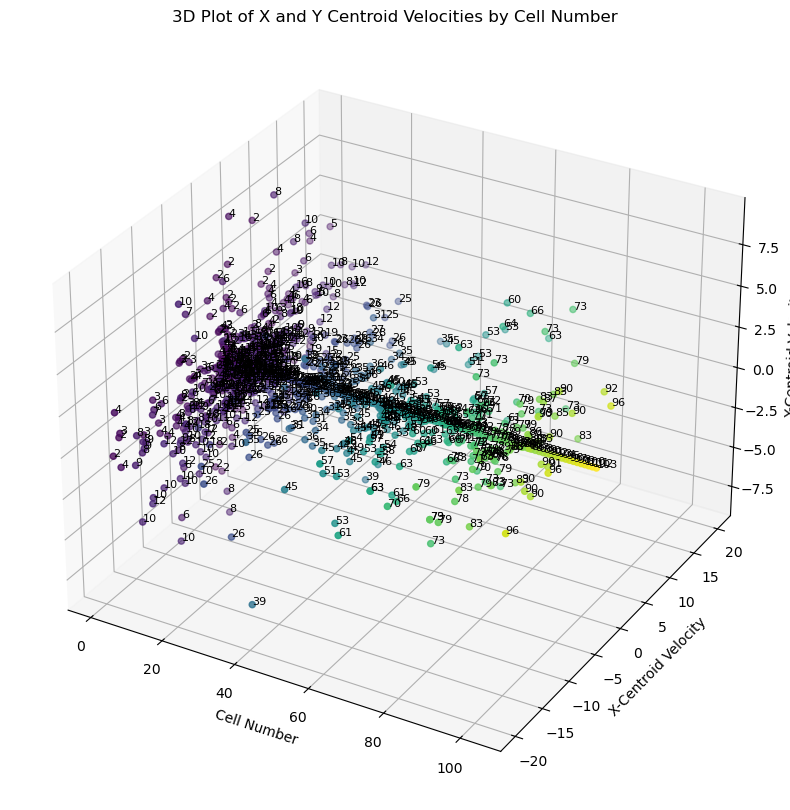

   Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
0            1      0  19791.0  1305.303607  0.745677  0.512826     0.145967   
1            1     22  15973.0  1015.605122  0.806229  0.676449     0.194602   
2            1     26  24764.0  1642.315801  0.796424  0.554153     0.115376   
3            2      0  20178.0   740.918831  0.827374  0.622240     0.461899   
4            2      1  20663.0   694.090404  0.849385  0.620678     0.538978   
5            2      2  19913.0   695.019336  0.831788  0.642853     0.518027   
6            2      3  18146.0   750.818326  0.806023  0.605432     0.404502   
7            2      4  20733.0   885.144228  0.790009  0.620823     0.332540   
8            2      5  17514.0   668.776695  0.863950  0.647995     0.492077   
9            2      6  19168.0   725.303607  0.834770  0.614359     0.457875   

   Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0    0.979877     0.936470   0.230860   341.783922   

In [9]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:

        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_sign-{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    for i, row in results_df.iterrows():
        ax.text(row["Cell Number"], row["X_Centroid_Velocity"], row["Y_Centroid_Velocity"], str(int(row["Cell Number"])), fontsize=8)
    ax.scatter(results_df["Cell Number"], results_df["X_Centroid_Velocity"], results_df["Y_Centroid_Velocity"], c=results_df["Cell Number"], cmap='viridis', marker='o')
    ax.set_xlabel("Cell Number")
    ax.set_ylabel("X-Centroid Velocity")
    ax.set_zlabel("Y-Centroid Velocity")
    ax.set_title("3D Plot of X and Y Centroid Velocities by Cell Number")
    plot_path = os.path.join(output_directory, "Cells_Centroid_Velocity_Plot.png")
    plt.savefig(plot_path)
    plt.show()
    
    return results_df


# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/02_RES"                           ####### Update with your directory path
# output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                               ####### Update with your desired output directory
# results_df = analyze_cells_across_frames(mask_directory, output_directory)


mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"                           
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              
results_df = analyze_cells_across_frames(mask_directory, output_directory)

####### Display the first few rows of the resulting DataFrame
print(results_df.head(10))


# visualize_3D_centroid_movement plot

In [10]:



# def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
#     """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
#     start_time = time.time()

#     def calculate_shape_factors(region):
#         """Calculate shape factors and centroid coordinates for a single region."""
#         area = region.area
#         perimeter = region.perimeter
#         convex_area = region.convex_area
#         bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

#         solidity = area / convex_area if convex_area > 0 else 0
#         extent = area / bounding_box_area if bounding_box_area > 0 else 0
#         circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

#         convex_mask = region.convex_image.astype(np.uint8) * 255
#         contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
#         convexity = convex_perimeter / perimeter if perimeter > 0 else 0

#         min_diameter = region.minor_axis_length
#         max_diameter = region.major_axis_length
#         elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
#         compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

#         centroid = region.centroid  # (y, x) format
#         cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

#         return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

#     if not os.path.exists(mask_directory):
#         raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

#     mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
#     if not mask_files:
#         raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

#     print(f"Found {len(mask_files)} mask files.")

#     all_results = []
#     cell_tracks = {}  # {Cell_ID: (x, y)}
#     previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
#     previous_frames = {}  # {Cell_ID: prev_frame}

#     current_cell_id = 1

#     for mask_path in mask_files:
#         frame_str = os.path.splitext(os.path.basename(mask_path))[0]
#         frame_match = re.search(r'\d+', frame_str)
#         frame = int(frame_match.group()) if frame_match else None
#         mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

#         if mask is None:
#             print(f"Skipping {frame}: Could not read {mask_path}.")
#             continue

#         labeled_mask = label(mask)
#         properties = regionprops(labeled_mask)

#         filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
#         if not filtered_regions:
#             print(f"Skipping frame {frame}: No valid cells detected.")
#             continue

#         used_cell_ids = set()
#         for region in filtered_regions:
#             shape_factors = calculate_shape_factors(region)
#             centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
#             matched_cell_id = None

#             for cell_id, prev_centroid in cell_tracks.items():
#                 if cell_id not in used_cell_ids:
#                     x_dist = abs(centroid[0] - prev_centroid[0])
#                     y_dist = abs(centroid[1] - prev_centroid[1])
#                     if x_dist <= max_centroid_dist and y_dist <= max_centroid_dist:
#                         matched_cell_id = cell_id
#                         used_cell_ids.add(cell_id)
#                         break

#             if matched_cell_id is None:
#                 matched_cell_id = current_cell_id
#                 used_cell_ids.add(matched_cell_id)
#                 current_cell_id += 1

#             prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
#             prev_frame = previous_frames.get(matched_cell_id, None)
#             if prev_x is not None and prev_y is not None and prev_frame is not None:
#                 frame_diff = frame - prev_frame
#                 x_centroid_distance = abs(centroid[0] - prev_x)
#                 y_centroid_distance = abs(centroid[1] - prev_y)
#                 x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
#                 y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
#             else:
#                 x_centroid_distance = 0
#                 y_centroid_distance = 0
#                 x_centroid_velocity = 0
#                 y_centroid_velocity = 0

#             previous_centroids[matched_cell_id] = centroid
#             previous_frames[matched_cell_id] = frame
#             cell_tracks[matched_cell_id] = centroid

#             all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

#     df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
#     fig = plt.figure(figsize=(10, 7))
#     ax = fig.add_subplot(111, projection='3d')
#     for i, row in df.iterrows():
#         ax.text(row["Cell Number"], row["X_Centroid_Velocity"], row["Y_Centroid_Velocity"], str(int(row["Cell Number"])), fontsize=8)
#     ax.scatter(df["Cell Number"], df["X_Centroid_Velocity"], df["Y_Centroid_Velocity"], c=df["Cell Number"], cmap='viridis', marker='o')
#     ax.set_xlabel("Cell Number")
#     ax.set_ylabel("X-Centroid Velocity")
#     ax.set_zlabel("Y-Centroid Velocity")
#     ax.set_title("3D Plot of X and Y Centroid Velocities by Cell Number")
#     plot_path = os.path.join(output_directory, "Cells_Centroid_Velocity_Plot.png")
#     plt.savefig(plot_path)
#     plt.show()
#     return df



# def visualize_3D_centroid_movement(results_df, output_directory):
#     """3D Plot of Cell Centroid Movement Over Frames with Cell Number Labels & Save the Plot."""
#     fig = plt.figure(figsize=(20, 16))  # Large plot size
#     ax = fig.add_subplot(111, projection='3d')

#     for cell_id, group in results_df.groupby("Cell Number"):
#         ax.plot(group["Centroid_X"], group["Centroid_Y"], group["Frame"], marker='o', linestyle='-')

#         last_row = group.iloc[-1]  # Last position of the cell
#         ax.text(last_row["Centroid_X"], last_row["Centroid_Y"], last_row["Frame"] + 1,  # Offset Z for clarity
#                 str(int(cell_id)), color='black', fontsize=14, weight='bold', ha='center')

#     ax.set_xlabel("Centroid X", fontsize=16)
#     ax.set_ylabel("Centroid Y", fontsize=16)
#     ax.set_zlabel("Frame (Time)", fontsize=16)
#     ax.set_title("3D Cell Centroid Movement Over Frames", fontsize=18)
#     ax.view_init(elev=25, azim=225)

#     os.makedirs(output_directory, exist_ok=True)
#     plot_filename = os.path.join(output_directory, "3D_Cell_Centroid_Movement_Over_Frame_HP3.png")
#     plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
#     print(f"3D plot saved at: {plot_filename}")

#     # plt.show()


#######  Example usage


# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"

# results_df = analyze_cells_across_frames(mask_directory, output_directory)



# plot of centroid velocities(Not Needed)

Found 100 mask files.


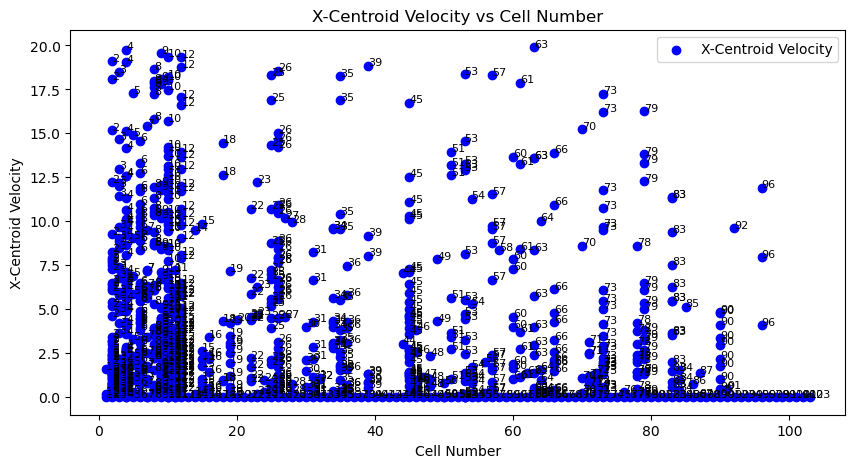

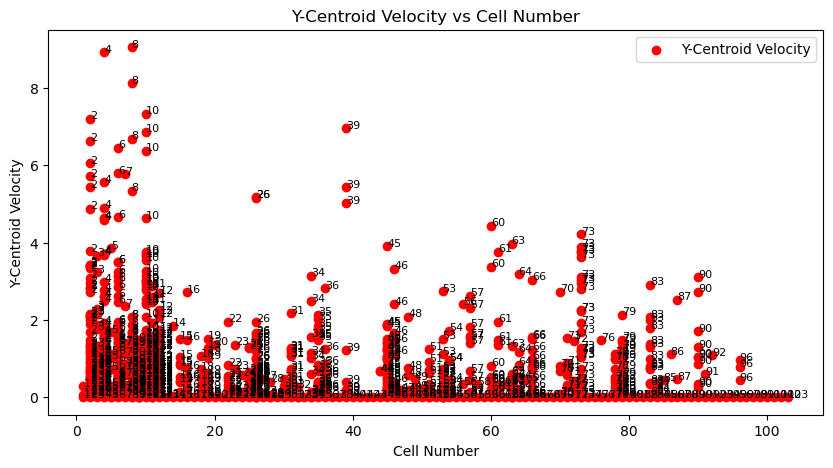

In [31]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = abs(centroid[0] - prev_centroid[0])
                    y_dist = abs(centroid[1] - prev_centroid[1])
                    if x_dist <= max_centroid_dist and y_dist <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = abs(centroid[0] - prev_x)
                y_centroid_distance = abs(centroid[1] - prev_y)
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    plt.figure(figsize=(10, 5))
    plt.scatter(df["Cell Number"], df["X_Centroid_Velocity"], c='b', label="X-Centroid Velocity")
    for i, row in df.iterrows():
        plt.text(row["Cell Number"], row["X_Centroid_Velocity"], str(int(row["Cell Number"])), fontsize=8)
    plt.xlabel("Cell Number")
    plt.ylabel("X-Centroid Velocity")
    plt.title("X-Centroid Velocity vs Cell Number")
    plt.legend()
    plt.savefig(os.path.join(output_directory, "X_Centroid_Velocity_vs_Cell_Number.png"))
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(df["Cell Number"], df["Y_Centroid_Velocity"], c='r', label="Y-Centroid Velocity")
    for i, row in df.iterrows():
        plt.text(row["Cell Number"], row["Y_Centroid_Velocity"], str(int(row["Cell Number"])), fontsize=8)
    plt.xlabel("Cell Number")
    plt.ylabel("Y-Centroid Velocity")
    plt.title("Y-Centroid Velocity vs Cell Number")
    plt.legend()
    plt.savefig(os.path.join(output_directory, "Y_Centroid_Velocity_vs_Cell_Number.png"))
    plt.show()
    
    
    return df


#######  Example usage


mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking/shape_measure"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

Found 100 mask files.


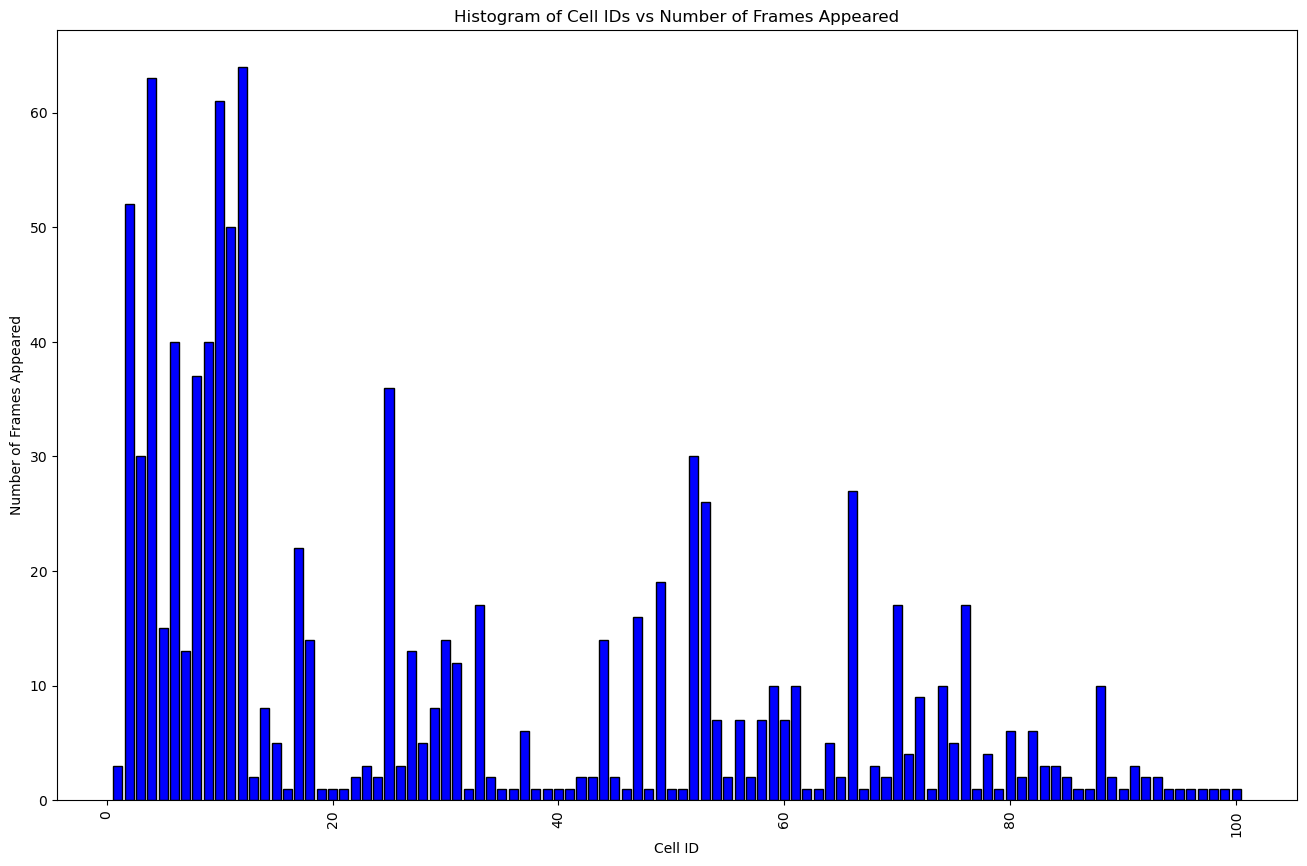

In [36]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = abs(centroid[0] - prev_centroid[0])
                    y_dist = abs(centroid[1] - prev_centroid[1])
                    if x_dist <= max_centroid_dist and y_dist <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = abs(centroid[0] - prev_x)
                y_centroid_distance = abs(centroid[1] - prev_y)
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    plt.figure(figsize=(16, 10))
    plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
    plt.xlabel("Cell ID")
    plt.ylabel("Number of Frames Appeared")
    plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
    plt.xticks(rotation=90)
    plt.savefig(os.path.join(output_directory, "Cell_IDs_vs_Frames_Distribution.png"))
    plt.show()
    
    return df


#######  Example usage


mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking/shape_measure"

results_df = analyze_cells_across_frames(mask_directory, output_directory)


# Histogram of Number cell  (Keep it , with sign)

Found 100 mask files.


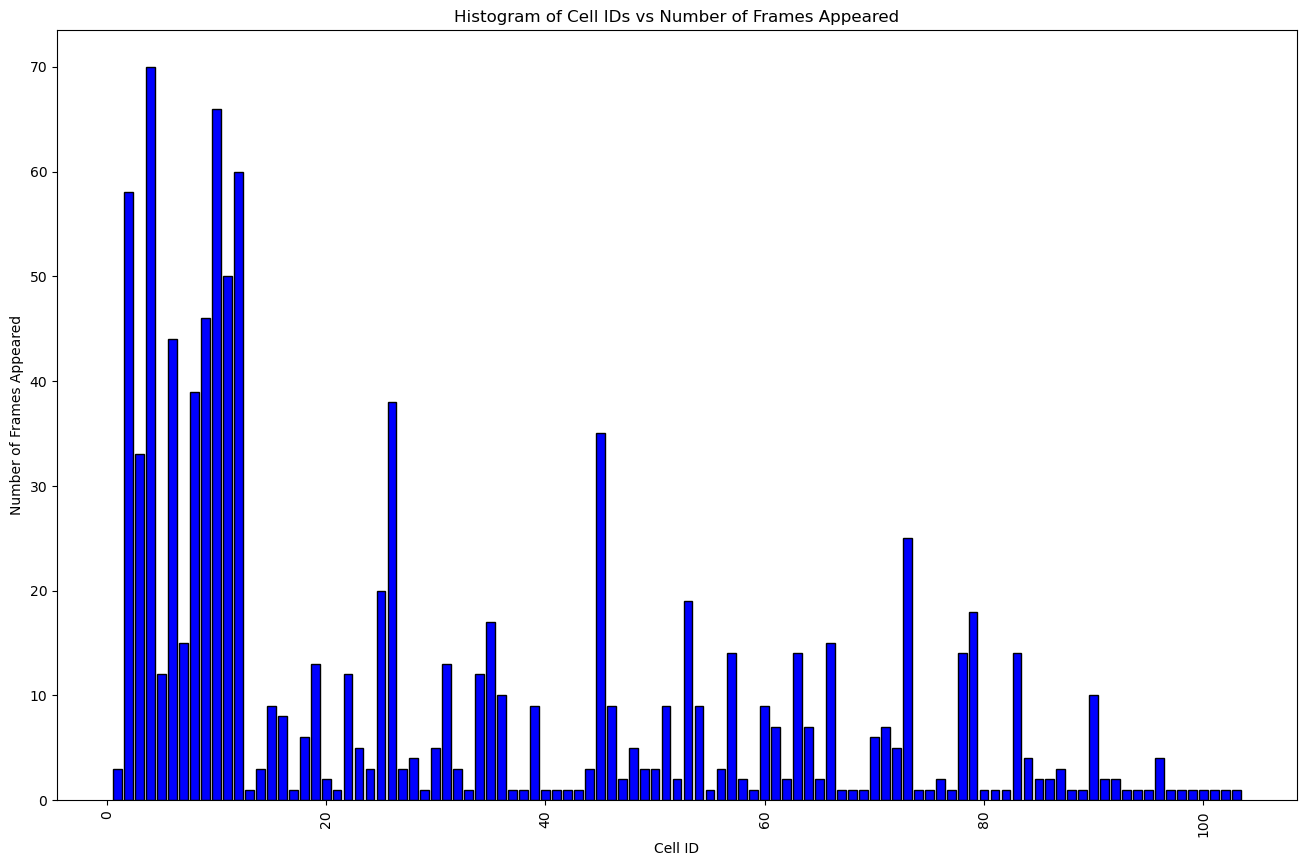

In [11]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    plt.figure(figsize=(16, 10))
    plt.bar(frame_counts.index, frame_counts.values, color='blue', edgecolor='black')
    plt.xlabel("Cell ID")
    plt.ylabel("Number of Frames Appeared")
    plt.title("Histogram of Cell IDs vs Number of Frames Appeared")
    plt.xticks(rotation=90)
    plt.savefig(os.path.join(output_directory, "Cell_IDs_vs_Frames_Distribution.png"))
    plt.show()
    
    return df


#######  Example usage
# mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/02_RES"
# output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"

# results_df = analyze_cells_across_frames(mask_directory, output_directory)



mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"                           
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              
results_df = analyze_cells_across_frames(mask_directory, output_directory)


# Count the number of times each cell appears (Keep it, with sign)

In [ ]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    frame_counts = df.groupby("Cell Number")["Frame"].nunique().reset_index()
    frame_counts.columns = ["Cell ID", "Number of Frames Appeared"]
    frame_counts.to_csv(os.path.join(output_directory, "Cell_IDs_Frame_Counts.csv"), index=False)
    
    print(frame_counts)
    return df

# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking/shape_measure"

# results_df = analyze_cells_across_frames(mask_directory, output_directory)



mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"                           
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              
results_df = analyze_cells_across_frames(mask_directory, output_directory)

Found 100 mask files.
     Cell ID  Number of Frames Appeared
0          1                          3
1          2                         58
2          3                         33
3          4                         70
4          5                         12
..       ...                        ...
98        99                          1
99       100                          1
100      101                          1
101      102                          1
102      103                          1

[103 rows x 2 columns]


# centroid distances, and velocities for the cell ID's where the number of frame is greater than 2

In [31]:




def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = abs(centroid[0] - prev_centroid[0])
                    y_dist = abs(centroid[1] - prev_centroid[1])
                    if x_dist <= max_centroid_dist and y_dist <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = abs(centroid[0] - prev_x)
                y_centroid_distance = abs(centroid[1] - prev_y)
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 3].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])
    
    frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
    frame_list.columns = ["Cell Number", "Frames Appeared"]
    print(frame_list)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_ABCD-{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return df

#######  Example usage


mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))

Found 100 mask files.
    Cell Number                                    Frames Appeared
0             1                                        [0, 22, 26]
1             2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...
2             3  [0, 1, 2, 4, 5, 8, 9, 16, 18, 19, 20, 34, 35, ...
3             4  [0, 2, 3, 4, 6, 7, 8, 10, 11, 19, 20, 21, 23, ...
4             5         [0, 2, 3, 4, 7, 8, 13, 14, 15, 72, 79, 85]
5             6  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
6             7  [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
7             8  [0, 1, 2, 3, 4, 37, 38, 45, 47, 49, 50, 51, 55...
8             9  [0, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, ...
9            10  [0, 3, 4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20,...
10           11  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
11           12  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
12           14                                        [1, 91, 93]
13           15                 [1, 9, 2

# X-centroid Velocity, Y-centroid Velocity for all cell ID's (Appeared at least 3 times) with sign

In [14]:


# def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
#     """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
#     start_time = time.time()

#     def calculate_shape_factors(region):
#         """Calculate shape factors and centroid coordinates for a single region."""
#         area = region.area
#         perimeter = region.perimeter
#         convex_area = region.convex_area
#         bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

#         solidity = area / convex_area if convex_area > 0 else 0
#         extent = area / bounding_box_area if bounding_box_area > 0 else 0
#         circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

#         convex_mask = region.convex_image.astype(np.uint8) * 255
#         contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
#         convexity = convex_perimeter / perimeter if perimeter > 0 else 0

#         min_diameter = region.minor_axis_length
#         max_diameter = region.major_axis_length
#         elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
#         compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

#         centroid = region.centroid  # (y, x) format
#         cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

#         return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

#     if not os.path.exists(mask_directory):
#         raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

#     mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
#     if not mask_files:
#         raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

#     print(f"Found {len(mask_files)} mask files.")

#     all_results = []
#     cell_tracks = {}  # {Cell_ID: (x, y)}
#     previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
#     previous_frames = {}  # {Cell_ID: prev_frame}

#     current_cell_id = 1

#     for mask_path in mask_files:
#         frame_str = os.path.splitext(os.path.basename(mask_path))[0]
#         frame_match = re.search(r'\d+', frame_str)
#         frame = int(frame_match.group()) if frame_match else None
#         mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

#         if mask is None:
#             print(f"Skipping {frame}: Could not read {mask_path}.")
#             continue

#         labeled_mask = label(mask)
#         properties = regionprops(labeled_mask)

#         filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
#         if not filtered_regions:
#             print(f"Skipping frame {frame}: No valid cells detected.")
#             continue

#         used_cell_ids = set()
#         for region in filtered_regions:
#             shape_factors = calculate_shape_factors(region)
#             centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
#             matched_cell_id = None

#             for cell_id, prev_centroid in cell_tracks.items():
#                 if cell_id not in used_cell_ids:
#                     x_dist = centroid[0] - prev_centroid[0]  # Keep sign
#                     y_dist = centroid[1] - prev_centroid[1]  # Keep sign
#                     if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
#                         matched_cell_id = cell_id
#                         used_cell_ids.add(cell_id)
#                         break

#             if matched_cell_id is None:
#                 matched_cell_id = current_cell_id
#                 used_cell_ids.add(matched_cell_id)
#                 current_cell_id += 1

#             prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
#             prev_frame = previous_frames.get(matched_cell_id, None)
#             if prev_x is not None and prev_y is not None and prev_frame is not None:
#                 frame_diff = frame - prev_frame
#                 x_centroid_distance = centroid[0] - prev_x  # Keep sign
#                 y_centroid_distance = centroid[1] - prev_y  # Keep sign
#                 x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
#                 y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
#             else:
#                 x_centroid_distance = 0
#                 y_centroid_distance = 0
#                 x_centroid_velocity = 0
#                 y_centroid_velocity = 0

#             previous_centroids[matched_cell_id] = centroid
#             previous_frames[matched_cell_id] = frame
#             cell_tracks[matched_cell_id] = centroid

#             all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])


#     df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
#     frame_counts = df.groupby("Cell Number")["Frame"].nunique()
#     valid_cells = frame_counts[frame_counts >= 3].index
#     df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])
    
#     frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
#     frame_list.columns = ["Cell Number", "Frames Appeared"]
    
#     os.makedirs(output_directory, exist_ok=True)
#     timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
#     df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_abcd-{timestamp}.csv"), index=False)
#     frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4-{timestamp}.csv"), index=False)
    
#     print(frame_list)
#     print(f"Execution Time: {time.time() - start_time:.2f} seconds")
#     return df





# #######  Example usage


# mask_directory = "/home/MinaHossain/DMNet_Rina_Tracking/shape_measure/HP4_TRA"
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking/shape_measure"

# results_df = analyze_cells_across_frames(mask_directory, output_directory)

# # Display the first few rows of the resulting DataFrame
# print(results_df.head(10))

# X-centroid Velocity, Y-centroid Velocity for all cell ID's (Appeared at least 3 times) with sign

In [15]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 3].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])
    
    frame_list = df.groupby("Cell Number")["Frame"].apply(list).reset_index()
    frame_list.columns = ["Cell Number", "Frames Appeared"]
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_abcd-{timestamp}.csv"), index=False)
    frame_list.to_csv(os.path.join(output_directory, f"Cells_Frames_List_HP4_Sign-{timestamp}.csv"), index=False)
    
    print(frame_list)
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return df


#######  Example usage
mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"

results_df = analyze_cells_across_frames(mask_directory, output_directory)

# Display the first few rows of the resulting DataFrame
print(results_df.head(15))


Found 100 mask files.
    Cell Number                                    Frames Appeared
0             1                                        [0, 22, 26]
1             2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...
2             3  [0, 1, 2, 4, 5, 8, 9, 16, 18, 19, 20, 34, 35, ...
3             4  [0, 2, 3, 4, 6, 7, 8, 10, 11, 19, 20, 21, 23, ...
4             5         [0, 2, 3, 4, 7, 8, 13, 14, 15, 72, 79, 85]
5             6  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
6             7  [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
7             8  [0, 1, 2, 3, 4, 37, 38, 45, 47, 49, 50, 51, 55...
8             9  [0, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, ...
9            10  [0, 3, 4, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20,...
10           11  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
11           12  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
12           14                                        [1, 91, 93]
13           15                 [1, 9, 2

# PCA for Clustering the cells that appears at least 3 frames

Found 100 mask files.
Execution Time: 20.85 seconds


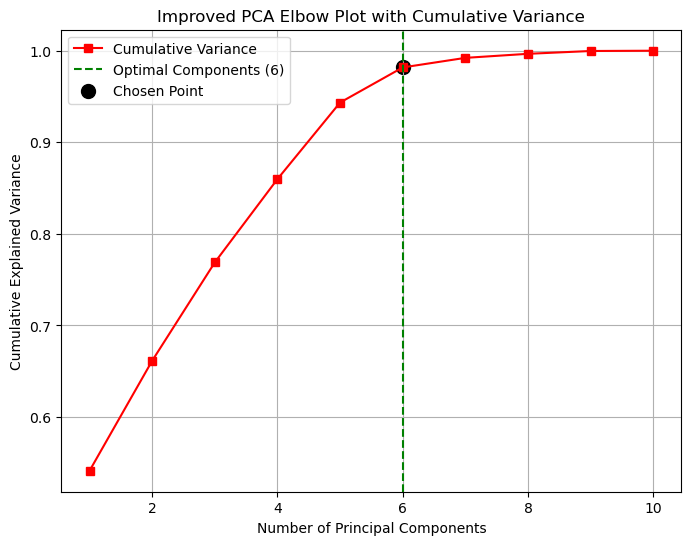

Optimal number of PCA components selected: 6


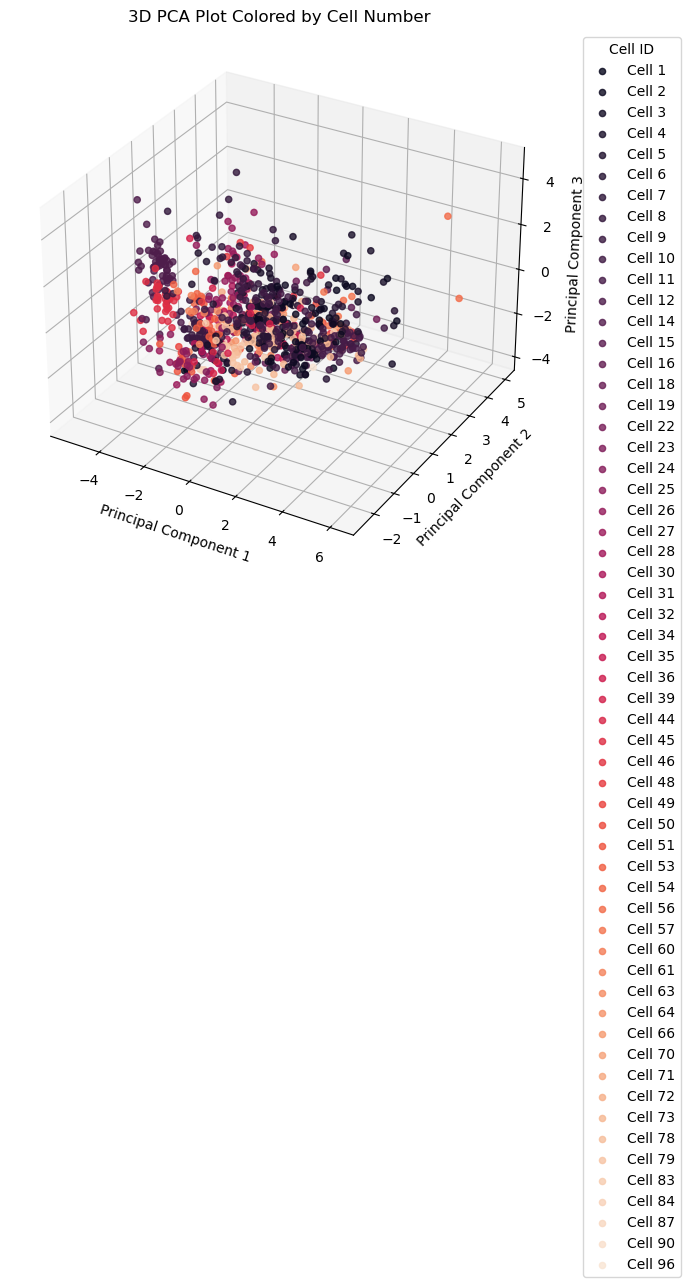

   Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
0            1      0  19791.0  1305.303607  0.745677  0.512826     0.145967   
1            1     22  15973.0  1015.605122  0.806229  0.676449     0.194602   
2            1     26  24764.0  1642.315801  0.796424  0.554153     0.115376   
3            2      0  20178.0   740.918831  0.827374  0.622240     0.461899   
4            2      1  20663.0   694.090404  0.849385  0.620678     0.538978   
5            2      2  19913.0   695.019336  0.831788  0.642853     0.518027   
6            2      3  18146.0   750.818326  0.806023  0.605432     0.404502   
7            2      4  20733.0   885.144228  0.790009  0.620823     0.332540   
8            2      5  17514.0   668.776695  0.863950  0.647995     0.492077   
9            2      6  19168.0   725.303607  0.834770  0.614359     0.457875   

   Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0    0.979877     0.936470   0.230860   341.783922   

In [19]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Ensure inclusion of cells appearing in at least 3 frames
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 3].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_PCA-{timestamp}.csv")
    df.to_csv(csv_path, index=False)
    
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return csv_path



def apply_pca(csv_path):
    """Load CSV, apply PCA with the optimal number of components, generate improved elbow plot, and create a 3D PCA plot."""
    
    # Load data
    df = pd.read_csv(csv_path)
    selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
                        "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
    mini_df = df[selected_columns].copy()
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df.drop(columns=["Cell Number"]))

    # PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

    # Determine the optimal number of components
    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1  # 95% variance threshold

    # Plot Elbow Graph with Cumulative Variance
    plt.figure(figsize=(8, 6))
    
    # Plot individual explained variance
    # plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label="Individual Variance")
    
    # Plot cumulative explained variance
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")

    # Highlight the elbow point
    plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
    plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=100, label="Chosen Point")
    
    # Add threshold reference lines
    # plt.axhline(y=0.85, color='gray', linestyle='--', alpha=0.6, label="85% Variance")
    # plt.axhline(y=0.95, color='gray', linestyle='--', alpha=0.6, label="95% Variance")

    # Labels and formatting
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Improved PCA Elbow Plot with Cumulative Variance")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Optimal number of PCA components selected: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    pca_result = pca.fit_transform(X_scaled)

    # Convert to DataFrame
    pca_columns = [f"PCA{i+1}" for i in range(optimal_components)]
    pca_df = pd.DataFrame(pca_result, columns=pca_columns)
    pca_df["Cell Number"] = mini_df["Cell Number"]

    # Unique colors for each Cell ID
    unique_cell_ids = pca_df["Cell Number"].unique()
    num_cells = len(unique_cell_ids)
    colors = sns.color_palette("rocket",  num_cells)  # Assign distinct colors

    # Create color mapping for Cell Numbers
    cell_color_map = {cell_id: colors[i % len(colors)] for i, cell_id in enumerate(unique_cell_ids)}
    pca_df["Color"] = pca_df["Cell Number"].map(cell_color_map)

    # 3D PCA Scatter Plot using the first 3 PCA components
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cell ID with its corresponding color
    for cell_id in unique_cell_ids:
        subset = pca_df[pca_df["Cell Number"] == cell_id]
        ax.scatter(subset["PCA1"], subset["PCA2"], subset["PCA3"], color=cell_color_map[cell_id], label=f"Cell {cell_id}", alpha=0.8)

    ax.set_title("3D PCA Plot Colored by Cell Number")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")

    # Add a proper legend mapping each color to a Cell ID
    ax.legend(title="Cell ID", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.show()



# def apply_pca(csv_path):
#     """Load CSV, apply PCA after standardization, generate elbow plot with cumulative variance, and create a 3D PCA plot with proper Cell ID labels."""
    
#     # Load data
#     df = pd.read_csv(csv_path)
#     selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
#                         "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
#     mini_df = df[selected_columns].copy()
    
#     # Standardize features
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(mini_df.drop(columns=["Cell Number"]))

#     # PCA for variance explanation
#     pca = PCA()
#     pca.fit(X_scaled)
    
#     explained_variance = pca.explained_variance_ratio_
#     cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

#     # Plot Elbow Graph with Cumulative Variance
#     plt.figure(figsize=(6, 4))
    
#     # Plot individual explained variance
#     plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label="Individual Variance")
    
#     # Plot cumulative explained variance
#     plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")
    
#     # Labels and formatting
#     plt.axhline(y=0.95, color='gray', linestyle='--', alpha=0.6)  # Show 95% threshold line
#     plt.xlabel("Number of Principal Components")
#     plt.ylabel("Explained Variance Ratio")
#     plt.title("Elbow Plot with Cumulative Explained Variance")
#     plt.legend()
#     plt.grid()
#     plt.show()

#     # Determine optimal number of components (first n where cumulative variance >= 95%)
#     optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
#     print(f"Optimal Number of PCA Components: {optimal_components}")

#     # Apply PCA for 3D Visualization with optimal components
#     pca = PCA(n_components=optimal_components)
#     pca_result = pca.fit_transform(X_scaled)

#     # Convert to DataFrame
#     pca_columns = [f"PCA{i+1}" for i in range(optimal_components)]
#     pca_df = pd.DataFrame(pca_result, columns=pca_columns)
#     pca_df["Cell Number"] = mini_df["Cell Number"]

#     # Unique colors for each Cell ID
#     unique_cell_ids = pca_df["Cell Number"].unique()
#     num_cells = len(unique_cell_ids)
#     colors = sns.color_palette("tab10", num_cells)  # Assign distinct colors

#     # Create color mapping for Cell Numbers
#     cell_color_map = {cell_id: colors[i] for i, cell_id in enumerate(unique_cell_ids)}
#     pca_df["Color"] = pca_df["Cell Number"].map(cell_color_map)

#     # 3D PCA Scatter Plot using the first 3 PCA components
#     fig = plt.figure(figsize=(12,8))
#     ax = fig.add_subplot(111, projection='3d')

#     # Plot each cell ID with its corresponding color
#     for cell_id in unique_cell_ids:
#         subset = pca_df[pca_df["Cell Number"] == cell_id]
#         ax.scatter(subset["PCA1"], subset["PCA2"], subset["PCA3"], color=cell_color_map[cell_id], label=f"Cell {cell_id}", alpha=0.8)

#     ax.set_title("3D PCA Plot Colored by Cell Number")
#     ax.set_xlabel("Principal Component 1")
#     ax.set_ylabel("Principal Component 2")
#     ax.set_zlabel("Principal Component 3")

#     # Add a proper legend mapping each color to a Cell ID
#     ax.legend(title="Cell ID", bbox_to_anchor=(1.05, 1), loc="upper left")
    
#     plt.show()
# Run
# csv_file = analyze_cells_across_frames("your_mask_directory", "your_output_directory")
# apply_pca(csv_file)

#######  Example usage


mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/HP4_TRA"
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"
csv_file = analyze_cells_across_frames(mask_directory, output_directory)

# csv_file = analyze_cells_across_frames("your_mask_directory", "your_output_directory")
apply_pca(csv_file)

# Display the first few rows of the resulting DataFrame
# Load the saved CSV file again
df = pd.read_csv(csv_file)  # Ensure csv_file contains the correct file path

# Display the first 15 rows
print(df.head(10))


In [ ]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  
    previous_centroids = {}  
    previous_frames = {}  

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = abs(centroid[0] - prev_centroid[0])
                    y_dist = abs(centroid[1] - prev_centroid[1])
                    if x_dist <= max_centroid_dist and y_dist <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = abs(centroid[0] - prev_x)
                y_centroid_distance = abs(centroid[1] - prev_y)
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    # Ensure inclusion of cells appearing in at least 3 frames
    frame_counts = df.groupby("Cell Number")["Frame"].nunique()
    valid_cells = frame_counts[frame_counts >= 3].index
    df = df[df["Cell Number"].isin(valid_cells)].sort_values(by=["Cell Number", "Frame"])

    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_PCA-{timestamp}.csv")
    df.to_csv(csv_path, index=False)
    
    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return csv_path



def apply_pca(csv_path):
    """Load CSV, apply PCA with the optimal number of components, generate improved elbow plot, and create a 3D PCA plot."""
    
    # Load data
    df = pd.read_csv(csv_path)
    selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
                        "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
    mini_df = df[selected_columns].copy()
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df.drop(columns=["Cell Number"]))

    # PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

    # Determine the optimal number of components
    optimal_components = np.argmax(cumulative_variance >= 0.90) + 1  # 95% variance threshold

    # Plot Elbow Graph with Cumulative Variance
    plt.figure(figsize=(8, 6))
    
    # Plot individual explained variance
    # plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label="Individual Variance")
    
    # Plot cumulative explained variance
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")

    # Highlight the elbow point
    plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
    plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=100, label="Chosen Point")
    
    # Add threshold reference lines
    # plt.axhline(y=0.85, color='gray', linestyle='--', alpha=0.6, label="85% Variance")
    # plt.axhline(y=0.95, color='gray', linestyle='--', alpha=0.6, label="95% Variance")

    # Labels and formatting
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Improved PCA Elbow Plot with Cumulative Variance")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Optimal number of PCA components selected: {optimal_components}")

    # Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    pca_result = pca.fit_transform(X_scaled)

    # Convert to DataFrame
    pca_columns = [f"PCA{i+1}" for i in range(optimal_components)]
    pca_df = pd.DataFrame(pca_result, columns=pca_columns)
    pca_df["Cell Number"] = mini_df["Cell Number"]

    # Unique colors for each Cell ID
    unique_cell_ids = pca_df["Cell Number"].unique()
    num_cells = len(unique_cell_ids)
    colors = sns.color_palette("rocket",  num_cells)  # Assign distinct colors

    # Create color mapping for Cell Numbers
    cell_color_map = {cell_id: colors[i % len(colors)] for i, cell_id in enumerate(unique_cell_ids)}
    pca_df["Color"] = pca_df["Cell Number"].map(cell_color_map)

    # 3D PCA Scatter Plot using the first 3 PCA components
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cell ID with its corresponding color
    for cell_id in unique_cell_ids:
        subset = pca_df[pca_df["Cell Number"] == cell_id]
        ax.scatter(subset["PCA1"], subset["PCA2"], subset["PCA3"], color=cell_color_map[cell_id], label=f"Cell {cell_id}", alpha=0.8)

    ax.set_title("3D PCA Plot Colored by Cell Number")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")

    # Add a proper legend mapping each color to a Cell ID
    ax.legend(title="Cell ID", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.show()



mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking/shape_measure"

csv_file = analyze_cells_across_frames(mask_directory, output_directory)

# csv_file = analyze_cells_across_frames("your_mask_directory", "your_output_directory")
apply_pca(csv_file)

# Display the first few rows of the resulting DataFrame
# Load the saved CSV file again
df = pd.read_csv(csv_file)  # Ensure csv_file contains the correct file path

# Display the first 15 rows
print(df.head(10))


Found 100 mask files.
Execution Time: 20.19 seconds


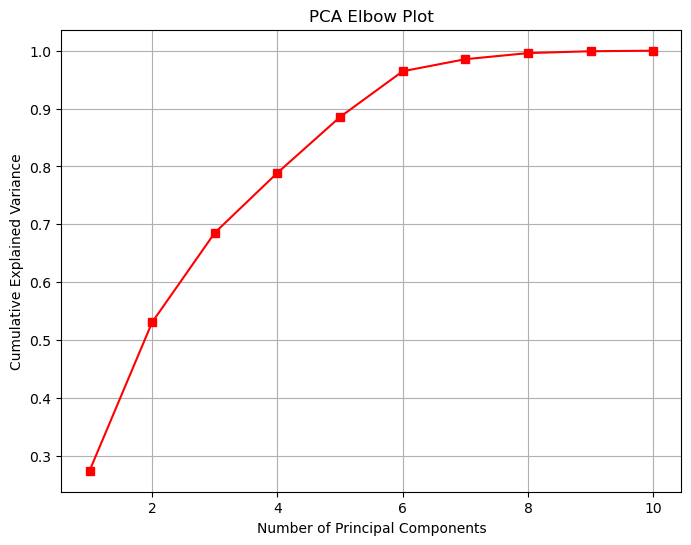

   Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
0            1      0   9949.0   822.008189  0.821146  0.538366     0.185028   
1            2      0  11383.0   843.960461  0.876694  0.646761     0.200827   
2            3      0  22532.0   804.954365  0.861249  0.604918     0.436986   
3            4      0  31837.0   870.380772  0.966779  0.711346     0.528109   
4            5      0  11467.0   697.806133  0.855363  0.634096     0.295931   
5            6      0  11495.0   806.835570  0.931599  0.699848     0.221896   
6            7      0  12771.0   781.764502  0.861799  0.718845     0.262593   
7            8      0  10191.0   661.983802  0.915058  0.736770     0.292235   
8            9      0  23537.0  1095.451840  0.759528  0.541080     0.246476   
9           10      0   3342.0   364.208153  0.836546  0.581217     0.316604   

   Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0    0.832779     0.874044   0.337517   309.878782   

In [12]:

def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  
    previous_centroids = {}  
    previous_frames = {}  

    current_cell_id = 1

    for mask_path in mask_files:
        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = centroid[0] - prev_centroid[0]  # Keep sign
                    y_dist = centroid[1] - prev_centroid[1]  # Keep sign
                    if abs(x_dist) <= max_centroid_dist and abs(y_dist) <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = centroid[0] - prev_x  # Keep sign
                y_centroid_distance = centroid[1] - prev_y  # Keep sign
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    df = pd.DataFrame(all_results, columns=["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"])
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4_PCA-{timestamp}.csv")
    df.to_csv(csv_path, index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return csv_path


def apply_pca(csv_path):
    """Load CSV, apply PCA with the optimal number of components, and create a 3D PCA plot."""
    
    df = pd.read_csv(csv_path)
    selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
                        "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
    mini_df = df[selected_columns].copy()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df.drop(columns=["Cell Number"]))

    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    optimal_components = np.argmax(cumulative_variance >= 0.90) + 1  

    pca = PCA(n_components=optimal_components)
    pca_result = pca.fit_transform(X_scaled)

    pca_columns = [f"PCA{i+1}" for i in range(optimal_components)]
    pca_df = pd.DataFrame(pca_result, columns=pca_columns)
    pca_df["Cell Number"] = mini_df["Cell Number"]

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red')
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Elbow Plot")
    plt.grid()
    plt.show()


mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/02_RES"
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"

csv_file = analyze_cells_across_frames(mask_directory, output_directory)
apply_pca(csv_file)

df = pd.read_csv(csv_file)
print(df.head(10))


# PCA for Clustering all the cells

Found 100 mask files.


Execution Time: 20.07 seconds


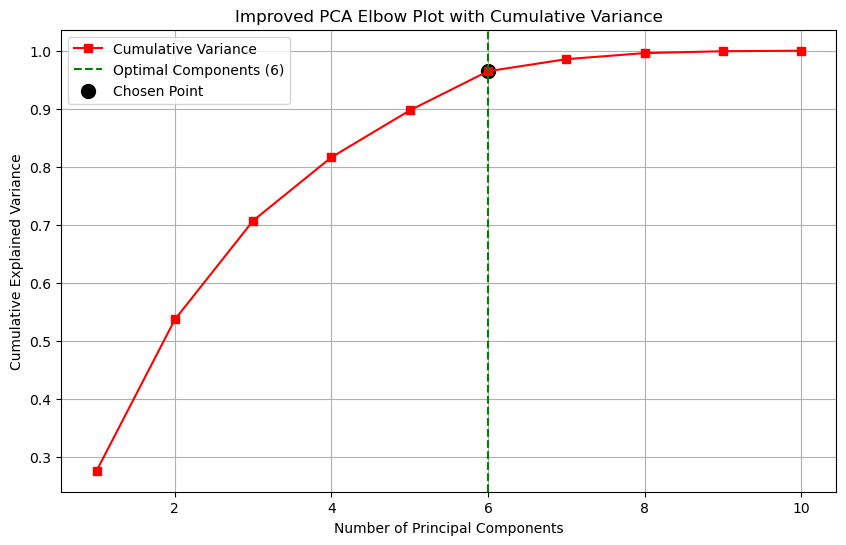

Optimal number of PCA components selected: 6


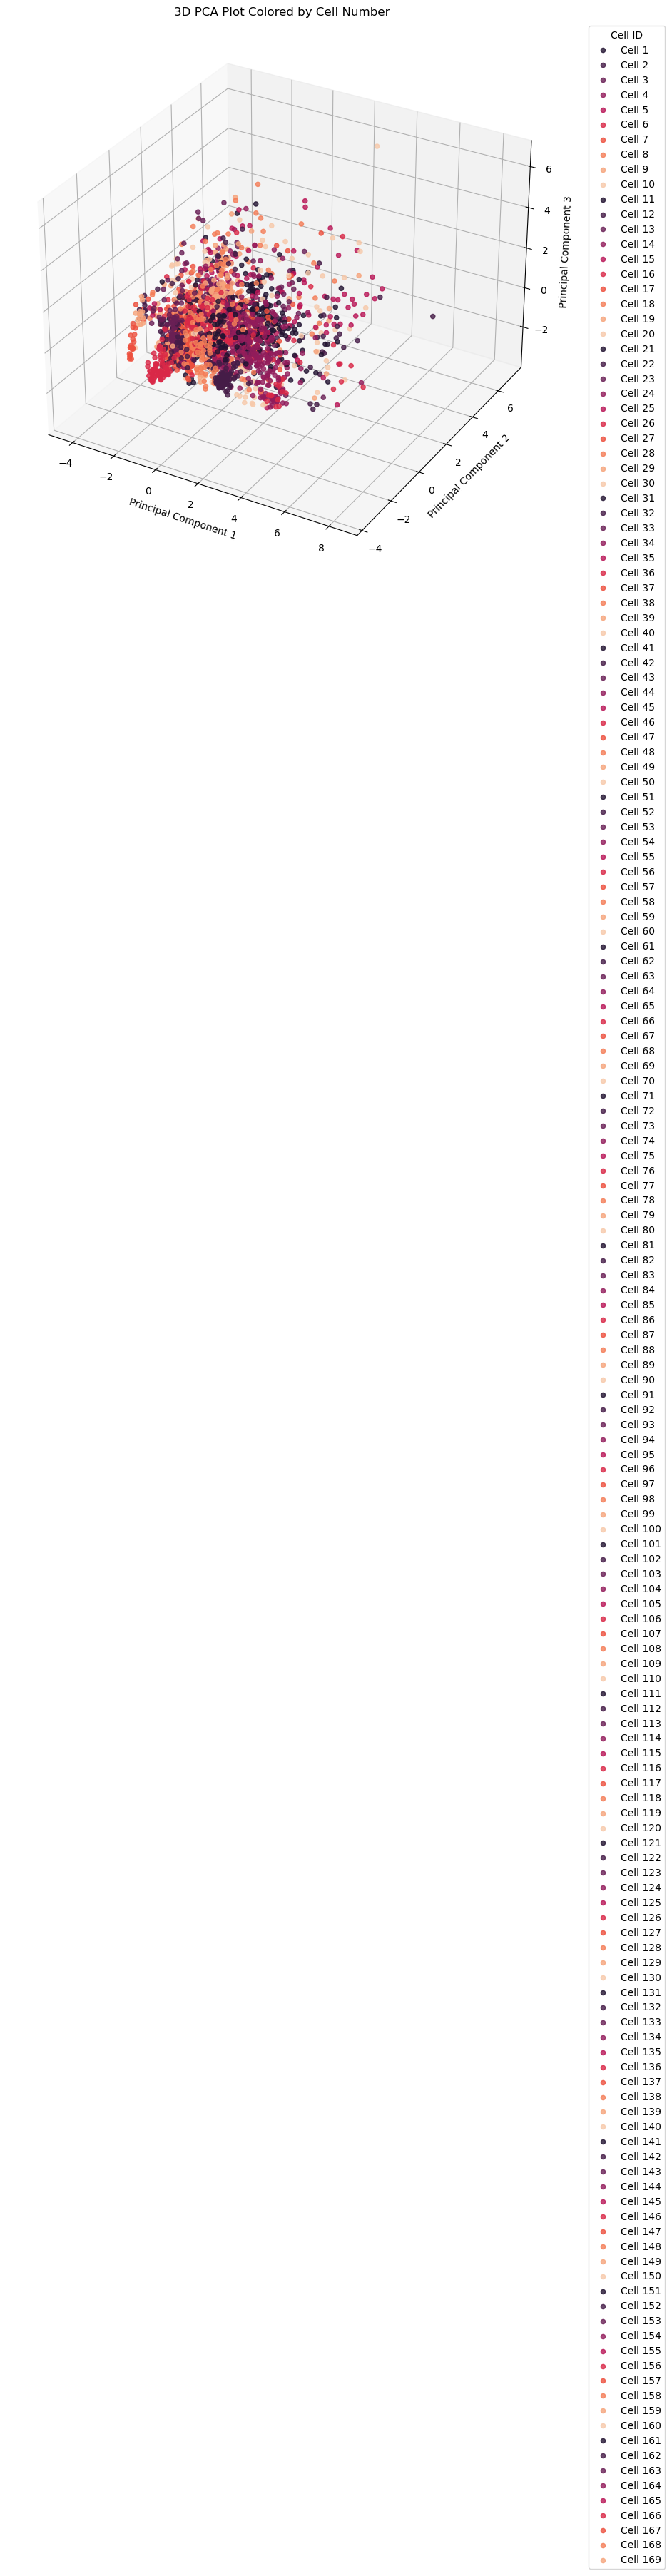

   Cell Number  Frame     Area   Perimeter    Extent  Solidity  Compactness  \
0            1      0   9949.0  822.008189  0.821146  0.538366     0.185028   
1            1      1   9713.0  812.286363  0.808406  0.562420     0.184989   
2            1      2  10552.0  827.984848  0.826635  0.546170     0.193419   
3            1      3   9347.0  775.102597  0.806123  0.531563     0.195508   
4            1      4  10094.0  836.801082  0.807972  0.542922     0.181146   
5            1      5  10168.0  799.723917  0.841374  0.548554     0.199786   
6            1      6  10759.0  849.404112  0.821611  0.539244     0.187393   
7            1      7  10979.0  823.238636  0.848192  0.527026     0.203573   
8            1      8  11247.0  825.386868  0.863560  0.562913     0.207459   
9            1      9  10986.0  821.410209  0.840358  0.535328     0.204611   

   Elongation  Circularity  Convexity  Centroid_X  Centroid_Y  \
0    0.832779     0.874044   0.337517  309.878782   54.868461   


In [2]:


def analyze_cells_across_frames(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20):
    """Analyze and track cells across frames, store shape factors, centroids, centroid distances, and velocities in a CSV file."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1] * 0.68, centroid[0] * 0.68  # Convert to (x, y) and apply scaling

        return [area, perimeter, solidity, extent, circularity, convexity, elongation, compactness, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}
    previous_frames = {}  # {Cell_ID: prev_frame}

    current_cell_id = 1

    for mask_path in mask_files:

        frame_str = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', frame_str)
        frame = int(frame_match.group()) if frame_match else None
        # frame = int(os.path.splitext(os.path.basename(mask_path))[0])
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids:
                    x_dist = abs(centroid[0] - prev_centroid[0])
                    y_dist = abs(centroid[1] - prev_centroid[1])
                    if x_dist <= max_centroid_dist and y_dist <= max_centroid_dist:
                        matched_cell_id = cell_id
                        used_cell_ids.add(cell_id)
                        break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            prev_frame = previous_frames.get(matched_cell_id, None)
            if prev_x is not None and prev_y is not None and prev_frame is not None:
                frame_diff = frame - prev_frame
                x_centroid_distance = abs(centroid[0] - prev_x)
                y_centroid_distance = abs(centroid[1] - prev_y)
                x_centroid_velocity = x_centroid_distance / frame_diff if frame_diff > 0 else 0
                y_centroid_velocity = y_centroid_distance / frame_diff if frame_diff > 0 else 0
            else:
                x_centroid_distance = 0
                y_centroid_distance = 0
                x_centroid_velocity = 0
                y_centroid_velocity = 0

            previous_centroids[matched_cell_id] = centroid
            previous_frames[matched_cell_id] = frame
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [x_centroid_distance, y_centroid_distance, x_centroid_velocity, y_centroid_velocity])

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "X_Centroid_Distance", "Y_Centroid_Distance", "X_Centroid_Velocity", "Y_Centroid_Velocity"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    os.makedirs(output_directory, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(os.path.join(output_directory, f"Cells_Centroid_Velocity_HP4-Full_PCA-{timestamp}.csv"), index=False)

    print(f"Execution Time: {time.time() - start_time:.2f} seconds")
    return results_df

    
    if results_df.empty:
        print("No valid data to process.")
        return None


def apply_pca(results_df):
    """Apply PCA, generate an improved elbow plot, and create a 3D PCA plot."""
    
    # ✅ Check if DataFrame is empty before proceeding
    if results_df.empty:
        print("Error: The provided DataFrame is empty. No PCA can be performed.")
        return
    
    # ✅ Check for required columns
    selected_columns = ["Cell Number", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
                        "Elongation", "Circularity", "Convexity", "X_Centroid_Velocity", "Y_Centroid_Velocity"]
    
    missing_columns = [col for col in selected_columns if col not in results_df.columns]
    if missing_columns:
        raise ValueError(f"Error: Missing required columns: {missing_columns}")

    mini_df = results_df[selected_columns].copy()
    
    # ✅ Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mini_df.drop(columns=["Cell Number"]))

    # ✅ PCA for variance explanation
    pca = PCA()
    pca.fit(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)  # Cumulative variance

    # ✅ Determine the optimal number of components (90% variance threshold)
    if np.any(cumulative_variance >= 0.95):
        optimal_components = np.argmax(cumulative_variance >= 0.95) + 1  
    else:
        optimal_components = len(cumulative_variance)  # Use all components if 90% is never reached

    # ✅ Plot Elbow Graph with Cumulative Variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', color='red', label="Cumulative Variance")

    # Highlight the elbow point
    plt.axvline(x=optimal_components, color='green', linestyle='--', label=f"Optimal Components ({optimal_components})")
    plt.scatter(optimal_components, cumulative_variance[optimal_components-1], color='black', s=100, label="Chosen Point")

    # Add threshold reference lines
    # plt.axhline(y=0.85, color='gray', linestyle='--', alpha=0.6, label="85% Variance")
    # plt.axhline(y=0.90, color='gray', linestyle='--', alpha=0.6, label="90% Variance")

    # Labels and formatting
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Improved PCA Elbow Plot with Cumulative Variance")
    plt.legend()
    plt.grid()
    plt.show()  # ✅ Ensure the plot displays

    print(f"Optimal number of PCA components selected: {optimal_components}")

    # ✅ Apply PCA with optimal components
    pca = PCA(n_components=optimal_components)
    pca_result = pca.fit_transform(X_scaled)

    # ✅ Convert to DataFrame
    pca_columns = [f"PCA{i+1}" for i in range(optimal_components)]
    pca_df = pd.DataFrame(pca_result, columns=pca_columns)
    pca_df["Cell Number"] = mini_df["Cell Number"]

    # ✅ Unique colors for each Cell ID
    unique_cell_ids = pca_df["Cell Number"].unique()
    num_cells = len(unique_cell_ids)

    # Ensure colors fit within seaborn's limit
    colors = sns.color_palette("rocket", min(num_cells, 10))  

    # Create color mapping for Cell Numbers
    cell_color_map = {cell_id: colors[i % len(colors)] for i, cell_id in enumerate(unique_cell_ids)}
    pca_df["Color"] = pca_df["Cell Number"].map(cell_color_map)

    # ✅ 3D PCA Scatter Plot using the first 3 PCA components
    if optimal_components >= 3:  # Ensure at least 3 components for 3D plotting
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Plot each cell ID with its corresponding color
        for cell_id in unique_cell_ids:
            subset = pca_df[pca_df["Cell Number"] == cell_id]
            ax.scatter(subset["PCA1"], subset["PCA2"], subset["PCA3"], color=cell_color_map[cell_id], label=f"Cell {cell_id}", alpha=0.8)

        ax.set_title("3D PCA Plot Colored by Cell Number")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.set_zlabel("Principal Component 3")

        # Add a proper legend mapping each color to a Cell ID
        ax.legend(title="Cell ID", bbox_to_anchor=(1.05, 1), loc="upper left")

        plt.show()  # ✅ Ensure the plot displays
    else:
        print("Warning: Optimal PCA components < 3. Skipping 3D plot.")
   


# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP4_TRA"                           ####### Update with your directory path
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking/shape_measure"                                              ####### Update with your desired output directory

mask_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/02_RES"                           ####### Update with your directory path
output_directory = "/home/MinaHossain/EmbedTrack/Shape_measure/"                                              ####### Update with your desired output directory

results_df = analyze_cells_across_frames(mask_directory, output_directory)
apply_pca(results_df)

# Display first few rows
if results_df is not None:
    print(results_df.head(10))

# t-SNE  Feature Plot with Cell Number Clustering

Found 100 mask files.


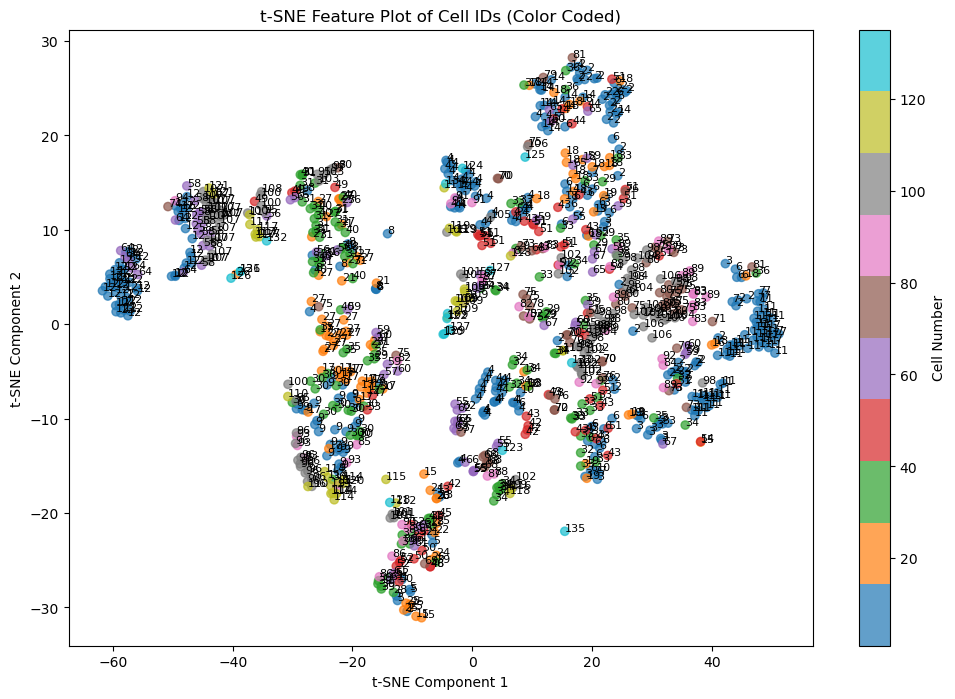

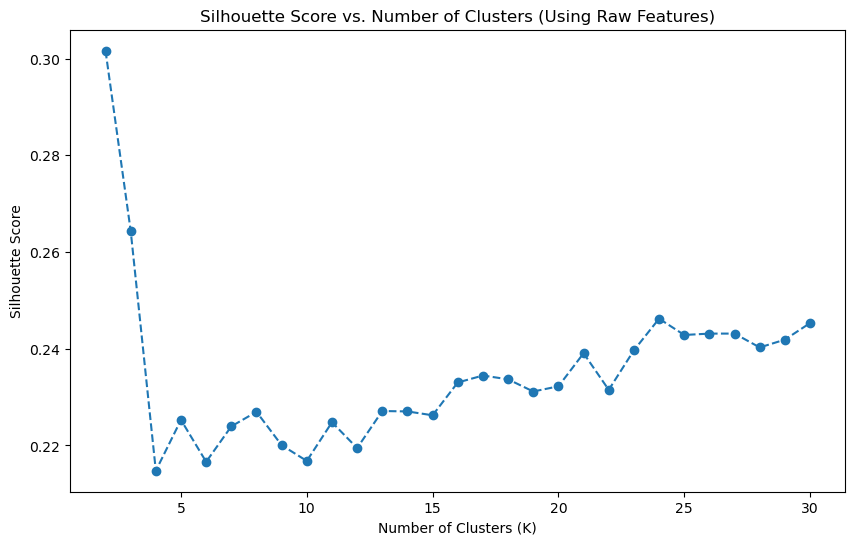

   Cell Number  Frame     Area    Perimeter    Extent  Solidity  Compactness  \
0            1      0  19221.0  1319.688384  0.493961  0.736014     0.226238   
1            1     22  15870.0   992.048773  0.644493  0.815896     0.285745   
2            1     26  23669.0  1603.244733  0.563279  0.796480     0.217443   
3            2      0  19719.0   728.676190  0.617299  0.825063     0.603899   
4            2      1  20319.0   693.605122  0.611834  0.842553     0.602088   

   Elongation  Circularity  Convexity   Centroid_X  Centroid_Y  \
0    0.938314     0.138689   0.975886   506.383747   88.009625   
1    0.908014     0.202638   0.981629   514.983176   97.383428   
2    0.945193     0.115715   0.981184   505.423508   97.804470   
3    0.562733     0.466687   0.918934  1924.020589  141.251686   
4    0.569925     0.530747   0.972914  1924.333875  143.253211   

   Centroid_Distance     tSNE_1     tSNE_2  
0           0.000000  -6.726557 -22.313328  
1          12.720785 -10.895315 

In [28]:


def analyze_and_cluster_cells(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20, max_k=30):
    """Analyze and track cells across frames, then apply PCA, K-Means clustering, and t-SNE visualization."""
    
    start_time = time.time()

    def calculate_shape_factors(region):
        """Calculate shape factors and centroid coordinates for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Convert convex_image to contours for accurate perimeter
        convex_mask = region.convex_image.astype(np.uint8) * 255
        contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex perimeter (sum of all contour lengths)
        convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        # Calculate centroid
        centroid = region.centroid  # (y, x) format
        cx, cy = centroid[1], centroid[0]  # Convert to (x, y)

        return [area, perimeter, extent, solidity, compactness, elongation, circularity, convexity, cx, cy]

    if not os.path.exists(mask_directory):
        raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

    mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
    if not mask_files:
        raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

    print(f"Found {len(mask_files)} mask files.")

    all_results = []
    cell_tracks = {}  # {Cell_ID: (x, y)}
    previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}

    current_cell_id = 1

    for mask_path in mask_files:
        filename = os.path.splitext(os.path.basename(mask_path))[0]
        frame_match = re.search(r'\d+', filename)
        frame = int(frame_match.group()) if frame_match else 0
        
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None:
            print(f"Skipping {frame}: Could not read {mask_path}.")
            continue

        labeled_mask = label(mask)
        properties = regionprops(labeled_mask)

        filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
        if not filtered_regions:
            print(f"Skipping frame {frame}: No valid cells detected.")
            continue

        used_cell_ids = set()
        for region in filtered_regions:
            shape_factors = calculate_shape_factors(region)
            centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
            matched_cell_id = None

            for cell_id, prev_centroid in cell_tracks.items():
                if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
                    matched_cell_id = cell_id
                    used_cell_ids.add(cell_id)
                    break

            if matched_cell_id is None:
                matched_cell_id = current_cell_id
                used_cell_ids.add(matched_cell_id)
                current_cell_id += 1

            prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
            centroid_distance = distance.euclidean((prev_x, prev_y), centroid) if prev_x is not None else 0

            previous_centroids[matched_cell_id] = centroid
            cell_tracks[matched_cell_id] = centroid

            all_results.append([matched_cell_id, frame] + shape_factors + [centroid_distance])

    columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
               "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "Centroid_Distance"]

    results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
    if results_df.empty:
        print("No valid data to process.")
        return None


     # Save DataFrame to output directory
    os.makedirs(output_directory, exist_ok=True)
    results_df.to_csv(os.path.join(output_directory, "cell_analysis_results_TSNE.csv"), index=False)


    # Standardize and Apply PCA
    selected_features = ["Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_Distance"]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(results_df[selected_features])
    pca = PCA(n_components=10)
    pca_features = pca.fit_transform(scaled_features)

    # Apply t-SNE on PCA features
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(pca_features)
    results_df["tSNE_1"] = tsne_results[:, 0]
    results_df["tSNE_2"] = tsne_results[:, 1]

    # # Plot t-SNE with only Cell IDs (No color)
    # plt.figure(figsize=(12,8))
    # for i, txt in enumerate(results_df["Cell Number"]):
    #     plt.annotate(txt, (results_df["tSNE_1"].iloc[i], results_df["tSNE_2"].iloc[i]), fontsize=8)
    # plt.scatter(results_df["tSNE_1"], results_df["tSNE_2"], alpha=0.5)
    # plt.xlabel("t-SNE Component 1")
    # plt.ylabel("t-SNE Component 2")
    # plt.title("t-SNE Cell ID Distribution")
    # plt.show()

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(results_df["tSNE_1"], results_df["tSNE_2"], c=results_df["Cell Number"], cmap='tab10', alpha=0.7)
    for i, txt in enumerate(results_df["Cell Number"]):
        plt.annotate(txt, (results_df["tSNE_1"].iloc[i], results_df["tSNE_2"].iloc[i]), fontsize=8)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Feature Plot of Cell IDs (Color Coded)")
    plt.colorbar(scatter, label="Cell Number")
    plt.show()
    

   

    # Standardize the features before clustering
    # scaler = StandardScaler()
    # scaled_features = scaler.fit_transform(results_df[selected_features])

    # Compute silhouette scores for different K values
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_features)
        silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='--')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs. Number of Clusters (Using Raw Features)")
    plt.show()


      
    return results_df


# Example usage
mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"
output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"

results_dff = analyze_and_cluster_cells(mask_directory, output_directory)

# Display first few rows
if results_dff is not None:
    print(results_dff.head())    


# pHate Feature Plot with Cell Number Clustering

In [39]:
# import os
# import time
# import re
# import numpy as np
# import pandas as pd
# import cv2
# import matplotlib.pyplot as plt
# import phate
# from scipy.spatial import distance
# from skimage.measure import label, regionprops
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import silhouette_score

# def analyze_and_cluster_cells(mask_directory, output_directory, size_threshold=1000, max_centroid_dist=20, max_k=30):
#     """Analyze and track cells across frames, then apply PCA, PHATE clustering, and visualization."""
    
#     start_time = time.time()

#     def calculate_shape_factors(region):
#         """Calculate shape factors and centroid coordinates for a single region."""
#         area = region.area
#         perimeter = region.perimeter
#         convex_area = region.convex_area
#         bounding_box_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])

#         solidity = area / convex_area if convex_area > 0 else 0
#         extent = area / bounding_box_area if bounding_box_area > 0 else 0
#         circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

#         # Convert convex_image to contours for accurate perimeter
#         convex_mask = region.convex_image.astype(np.uint8) * 255
#         contours, _ = cv2.findContours(convex_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#         # Compute convex perimeter (sum of all contour lengths)
#         convex_perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours) if contours else 0
#         convexity = convex_perimeter / perimeter if perimeter > 0 else 0

#         min_diameter = region.minor_axis_length
#         max_diameter = region.major_axis_length
#         elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
#         compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

#         # Calculate centroid
#         centroid = region.centroid  # (y, x) format
#         cx, cy = centroid[1], centroid[0]  # Convert to (x, y)

#         return [area, perimeter, extent, solidity, compactness, elongation, circularity, convexity, cx, cy]

#     if not os.path.exists(mask_directory):
#         raise FileNotFoundError(f"Error: The directory {mask_directory} does not exist.")

#     mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith(".tif")])
#     if not mask_files:
#         raise FileNotFoundError(f"No TIFF files found in {mask_directory}. Check your file paths.")

#     print(f"Found {len(mask_files)} mask files.")

#     all_results = []
#     cell_tracks = {}  # {Cell_ID: (x, y)}
#     previous_centroids = {}  # {Cell_ID: (prev_x, prev_y)}

#     current_cell_id = 1

#     for mask_path in mask_files:
#         filename = os.path.splitext(os.path.basename(mask_path))[0]
#         frame_match = re.search(r'\d+', filename)
#         frame = int(frame_match.group()) if frame_match else 0
        
#         mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

#         if mask is None:
#             print(f"Skipping {frame}: Could not read {mask_path}.")
#             continue

#         labeled_mask = label(mask)
#         properties = regionprops(labeled_mask)

#         filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]
#         if not filtered_regions:
#             print(f"Skipping frame {frame}: No valid cells detected.")
#             continue

#         used_cell_ids = set()
#         for region in filtered_regions:
#             shape_factors = calculate_shape_factors(region)
#             centroid = (shape_factors[-2], shape_factors[-1])  # Extract (x, y) from shape factors
#             matched_cell_id = None

#             for cell_id, prev_centroid in cell_tracks.items():
#                 if cell_id not in used_cell_ids and distance.euclidean(centroid, prev_centroid) <= max_centroid_dist:
#                     matched_cell_id = cell_id
#                     used_cell_ids.add(cell_id)
#                     break

#             if matched_cell_id is None:
#                 matched_cell_id = current_cell_id
#                 used_cell_ids.add(matched_cell_id)
#                 current_cell_id += 1

#             prev_x, prev_y = previous_centroids.get(matched_cell_id, (None, None))
#             centroid_distance = distance.euclidean((prev_x, prev_y), centroid) if prev_x is not None else 0

#             previous_centroids[matched_cell_id] = centroid
#             cell_tracks[matched_cell_id] = centroid

#             all_results.append([matched_cell_id, frame] + shape_factors + [centroid_distance])

#     columns = ["Cell Number", "Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness",
#                "Elongation", "Circularity", "Convexity", "Centroid_X", "Centroid_Y", "Centroid_Distance"]

#     results_df = pd.DataFrame(all_results, columns=columns).sort_values(by=["Cell Number", "Frame"]).reset_index(drop=True)
    
#     if results_df.empty:
#         print("No valid data to process.")
#         return None

#     # Save DataFrame
#     os.makedirs(output_directory, exist_ok=True)
#     results_df.to_csv(os.path.join(output_directory, "cell_analysis_results_PHATE.csv"), index=False)

#     # Standardize features and apply PCA
#     selected_features = ["Frame", "Area", "Perimeter", "Extent", "Solidity", "Compactness", "Elongation", "Circularity", "Convexity", "Centroid_Distance"]
#     scaler = StandardScaler()
#     scaled_features = scaler.fit_transform(results_df[selected_features])

#     pca = PCA(n_components=10)
#     pca_features = pca.fit_transform(scaled_features)

#     # Apply PHATE
#     phate_operator = phate.PHATE()
#     phate_results = phate_operator.fit_transform(pca_features)

#     results_df["PHATE_1"] = phate_results[:, 0]
#     results_df["PHATE_2"] = phate_results[:, 1]

#     # Visualize PHATE embeddings
#     plt.figure(figsize=(12, 8))
#     scatter = plt.scatter(results_df["PHATE_1"], results_df["PHATE_2"], c=results_df["Cell Number"], cmap='tab10', alpha=0.7)
#     plt.xlabel("PHATE Component 1")
#     plt.ylabel("PHATE Component 2")
#     plt.title("PHATE Feature Plot of Cell IDs (Color Coded)")
#     plt.colorbar(scatter, label="Cell Number")
#     plt.show()

#     # Apply clustering on PHATE embeddings
#     silhouette_scores = []
#     for k in range(2, max_k + 1):
#         kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#         cluster_labels = kmeans.fit_predict(phate_results)
#         silhouette_scores.append(silhouette_score(phate_results, cluster_labels))

#     # Plot silhouette scores
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='--')
#     plt.xlabel("Number of Clusters (K)")
#     plt.ylabel("Silhouette Score")
#     plt.title("Silhouette Score vs. Number of Clusters (Using PHATE Features)")
#     plt.show()

#     return results_df


# # Example usage
# mask_directory = "/data/MinaHossain/Cell_Data/Fall-2024/Track_Result/HP3_TRA"
# output_directory = "/home/MinaHossain/DMNet_Rina_Tracking"

# results_dff = analyze_and_cluster_cells(mask_directory, output_directory)

# # Display first few rows
# if results_dff is not None:
#     print(results_dff.head())   
